<a href="https://colab.research.google.com/github/sanjaynagi/primerDesignAg/blob/main/Primer-Design-in-Anopheles-gambiae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, install some packages we require
!pip install agamPrimer==0.1.5 primer3-py malariagen_data scikit-allel -q 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 397 kB 23.7 MB/s 
     |████████████████████████████████| 61 kB 344 kB/s 
     |████████████████████████████████| 5.7 MB 43.5 MB/s 
     |████████████████████████████████| 3.3 MB 59.5 MB/s 
     |████████████████████████████████| 2.3 MB 46.3 MB/s 
     |████████████████████████████████| 140 kB 56.7 MB/s 
     |████████████████████████████████| 300 kB 57.9 MB/s 
     |████████████████████████████████| 153 kB 68.0 MB/s 
     |████████████████████████████████| 1.1 MB 46.3 MB/s 
     |████████████████████████████████| 144 kB 58.5 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 271 kB 58.4 MB/s 
     |████████████████████████████████| 6.2 MB 34.3 MB/s 


In [2]:
# Import libraries 
import agamPrimer
import pandas as pd 
import allel 
import malariagen_data
import numpy as np
import primer3
import seaborn as sns
import matplotlib.pyplot as plt

#**Primer design incorporating genetic variation in *Anopheles gambiae***
**Author**: Sanjay Curtis Nagi    
**Email**: sanjay.nagi@lstmed.ac.uk




Often, we would like to design primers for PCR applications, such as genotyping (PCR, TaqMan, LNA) or gene expression qPCR (SYBR, TaqMan, LNA). However, single nucleotide polymorphisms (SNPs) in primer binding sites can result in differences or failures in PCR amplification, referred to as null alleles. 

In general, mismatches caused by SNPs, are more of a problem as you move towards the 3' end. I recommend reading a really good article on this topic on the IDT website - [Consider SNPs when designing PCR and qPCR assays](https://eu.idtdna.com/pages/education/decoded/article/considering-snps-when-designing-pcr-and-qpcr-assays). In *An. gambiae s.l*, there is a [huge amount of genetic variation](https://genome.cshlp.org/content/30/10/1533.full); a SNP found approximately every 1.9 bases (!), which makes considering SNPs even more important when designing molecular assays. Thanks to primer3-py and the fantastic malariagen_data package, we can do all of this in the cloud, hosted by google!


###**Google Colab**

If you are unfamiliar with iPython notebooks and google colab, I encourage you to watch the following [introduction](https://www.youtube.com/watch?v=inN8seMm7UI). In general, the cells can be run by pressing the play button next to each cell, and should be run in order.

###**Future development**

Currently, the notebook supports only standard genomic DNA primers, however, we will add support for qPCR primers (which should span exon-exon junctions) and probe design. It will probably also be useful to have some form of batch primer design. In the case that there are less acceptable primers than requested, or Ns in the referene, currently i think the workflow will break.

Any contributions or suggestions on how we can improve this notebook, are more than welcome. 

#### **Primer Design**
Set up our primer choices.

In [18]:
assay_type = 'qPCR' #'gDNA'
name = 'coeae1f'                      # Name for primer set
contig = '2L'                         # Contig out of 2L, 2R, 3L, 3R and X
amplicon_size_range = [[125,225]]     # How large do we want the amplicon to be? here, e.g 125-225bp
n_primer_pairs = 20                   # How many primer pairs to request

target_loc = 28_525_000               # gDNA primers only. This should be the location in base pairs of where you want the primers to target. underscores mean nothing and are just helpful for reading large numbers. 
transcript = 'AGAP006227-RA'                   # qPCR primers only.  

Load sequence data for chromosomal arm of choice:

In [4]:
# Connect to the malariagen_data ag3 API
ag3 = malariagen_data.Ag3() #pre=True
genome_seq = ag3.genome_sequence(region=contig)
print(f"Our genome sequence for {contig} is {genome_seq.shape[0]} bp long")

Our genome sequence for 2L is 49364325 bp long


Now we need to extract the bit of sequence we need. We will use the functions we defined at the top of the notebook. Depending on our requirements, the approaches in the functions will differ:

**gDNA primers**
1. Subset the genome sequence to our target location, flanked by n bases either side. For n, we take the middle of the required amplicon size range (this provides plenty of space on each flank).
2. Record the genomic position of each base in the sequence.
3. Locate the new index of the target location in the target sequence, which we will pass to primer3.

**qPCR primers** 
1.   Load the *An.gambiae* geneset for our transcript, which includes the start and end position of all exons.
2.   Get the DNA sequence for each exon, and concatenate them together. 
3. Record the genomic position of each base in the sequence. 
4. Find exon-exon junctions, locating their index in the target sequence (which we will pass to primer3), and their genomic position.

In [5]:
if assay_type == 'gDNA':
  # genomic DNA
  target_sequence, target_loc_primer3, gdna_pos = agamPrimer.prepare_gDNA_sequence(target_loc=target_loc, amplicon_size_range=amplicon_size_range, genome_seq=genome_seq)
elif assay_type == 'qPCR':
  # quantitative PCR 
  target_sequence, exon_junctions, gdna_pos = agamPrimer.prepare_cDNA_sequence(transcript=transcript, gff=ag3.geneset(), genome_seq=genome_seq)

Exon junctions for AGAP006227-RA: [ 375  629  973 1364 1514 1651] [28545771, 28546096, 28546517, 28546975, 28547196, 28547556] 



Now we have our target sequence.

We need to set up some python dictionaries containing our sequence and primer parameters, this will be our input to primer3. 
 
Here, you can modify primer3 parameters, such as optimal TM, GC content etc etc. A full list of possible parameters and their functions can be found in the [primer3 manual](https://primer3.org/manual.html). For qPCR primers, please remove the 'SEQUENCE_TARGET' line, and add the 'SEQUENCE_OVERLAP_JUNCTION_LIST' line.

In [6]:
seq_parameters = {
        'SEQUENCE_ID': name,
        'SEQUENCE_TEMPLATE': target_sequence,
    #   'SEQUENCE_TARGET': target_loc_primer3,                   ## for gDNA primers only ##
        'SEQUENCE_OVERLAP_JUNCTION_LIST': exon_junctions,       ## For qPCR primers only # remove or comment out line for gDNA primers
    }
    
primer_parameters  =  {
        'PRIMER_NUM_RETURN':n_primer_pairs,
        'PRIMER_OPT_SIZE': 20,
        'PRIMER_PICK_RIGHT_PRIMER':1,
        'PRIMER_PICK_INTERNAL_OLIGO': 0, 
        'PRIMER_PICK_LEFT_PRIMER':1,
        'PRIMER_TASK':'generic',
        'PRIMER_MIN_SIZE': 17,
        'PRIMER_MAX_SIZE': 24,
        'PRIMER_OPT_TM': 60.0,
        'PRIMER_MIN_TM': 57.0,
        'PRIMER_MAX_TM': 63.0,
        'PRIMER_MIN_GC': 30.0,
        'PRIMER_MAX_GC': 75.0,
        'PRIMER_PRODUCT_SIZE_RANGE': amplicon_size_range,
        'PRIMER_EXPLAIN_FLAG':1,
        'PRIMER_MIN_THREE_PRIME_DISTANCE':3                           
    }

#### **Run the primer3 algorithm!**

In [7]:
primer_dict = primer3.designPrimers(seq_args=seq_parameters, global_args=primer_parameters)

Its should be very fast. The output, which we call 'primer_dict', is a python dictionary containing the full results from primer3. We will turn this into a pandas dataframe, containing just the necessary bits of information. First, lets print some information from the primer3 run. The first 7 rows of the data frame are general statistics from the run. 

In [8]:
primer_df = pd.DataFrame.from_dict(primer_dict.items())          # Convert the dict into a pandas dataframe
primer_df = primer_df.rename(columns={0:'parameter', 1:'value'}) # Rename the columns
explanations_df = primer_df.iloc[:7, :]                          # Take the first 7 rows which are general

for idx, row in explanations_df.iterrows():                      # Loop through each row and print information
    print(row['parameter'], " : ", row['value'], "\n")

PRIMER_LEFT_EXPLAIN  :  considered 14624, GC content failed 1124, low tm 4557, high tm 4034, high hairpin stability 10, ok 4899 

PRIMER_RIGHT_EXPLAIN  :  considered 14624, GC content failed 482, low tm 4702, high tm 4238, high any compl 1, high hairpin stability 7, ok 5194 

PRIMER_PAIR_EXPLAIN  :  considered 430469, unacceptable product size 2602, no overlap of required point 427842, primer in pair overlaps a primer in a better pair 35275, ok 25 

PRIMER_LEFT_NUM_RETURNED  :  20 

PRIMER_RIGHT_NUM_RETURNED  :  20 

PRIMER_INTERNAL_NUM_RETURNED  :  0 

PRIMER_PAIR_NUM_RETURNED  :  20 



Now lets wrangle this into an easy to look at table.

In [9]:
# Create a column which is primer pair #, and a column for primer parameter which does not contain primer pair #
primer_df = primer_df.iloc[7:, :].copy()
primer_df['primer_pair'] = primer_df['parameter'].str.extract("([0-9][0-9]|[0-9])")
primer_df['parameter'] = primer_df['parameter'].str.replace("(_[0-9][0-9]|_[0-9])", "", regex=True)

# Put the different primer pairs in different columns
primer_df = primer_df.pivot(index='parameter', columns='primer_pair', values='value')

# Get a list of the rows we need 
primer_span = ['PRIMER_LEFT', 'PRIMER_RIGHT']
required_info = ['SEQUENCE', 'TM', 'GC_PERCENT']
required_info = [p + "_" + y for y in required_info for p in primer_span] + primer_span + ['PRIMER_PAIR_PRODUCT_SIZE']

# Subset data frame
primer_df = primer_df.loc[required_info, np.arange(primer_df.shape[1]).astype(str)]
primer_df

primer_pair,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
parameter,,,,,,,,,,,,,,,,,,,,
PRIMER_LEFT_SEQUENCE,TCCGAAAGCTCCAATGCGAT,CAGCATGCGTCTCATTTCCG,AACAACTCGACCAGCGTTTG,AGCTTATCGGTCATGAGCGT,AACTCGACCAGCGTTTGCAT,AGCTCACACCGCCATTGTTA,TTGCCGGTTTGAGCTCTTTC,AGTAAACAACTCGACCAGCGT,GGTATGCCAAGCTCCTTCGA,TGGCAGCTCCAGATCCTTAA,CCATTACCGGGCGCAATTTT,TCAAACCACCATTTCCGGGT,GCAGCTCCAGATCCTTAAAGC,ATTTTGCCGGTTTGAGCTCT,CGAATCGAGGGACAAAAATCCG,AACGAATCCCACAGCAGCAT,CACCGAACAGCGTCACATTG,GGGACAAAAATCCGAAAGCTCC,CCGGTTTGAGCTCTTTCGTG,CGCACGTTACGATCGCAAAA
PRIMER_RIGHT_SEQUENCE,CACGAAAGAGCTCAAACCGG,CAAACGCTGGTCGAGTTGTT,GTCTGCTCGAGGATCAGCTC,AACGCCGAGGAAGGATTGTT,AGGATCAGCTCCCAAAAGCC,ATGCAAACGCTGGTCGAGTT,ATCGGTGAGCGACGCTTTAA,GTCTACCGGTTTGCAGTGGA,GAAAGAGCTCAAACCGGCAA,AAAATGAGCCAGCCCGATCA,TTAAGGATCTGGAGCTGCCA,AGAGCTCAAACCGGCAAAAT,AAACGTGATCTGCTCCGGTT,GGTGAGCGACGCTTTAAGGA,ACAAGATCGTGGGCAGTGAG,AACGCTGGTCGAGTTGTTTAC,GGAGCTTTCGGATTTTTGTCCC,AAAATTGCGCCCGGTAATGG,ACGCTTTAAGGATCTGGAGCT,GGCTATTTAACGCTCATGACCG
PRIMER_LEFT_TM,60.107703,59.972806,59.344267,59.252745,60.884704,59.963836,59.048442,59.931873,59.821932,58.416444,59.825383,59.813614,59.053919,58.379178,59.969543,60.322816,60.110688,60.0947,59.487048,60.17927
PRIMER_RIGHT_TM,59.487048,59.344267,59.969362,59.963694,60.033699,60.884704,60.108992,59.965663,59.048442,60.034186,58.416444,58.379178,59.965104,60.389426,60.036952,59.137173,60.0947,59.825383,59.165737,59.778945
PRIMER_LEFT_GC_PERCENT,50.0,55.0,50.0,50.0,50.0,50.0,50.0,47.619048,55.0,50.0,50.0,50.0,52.380952,45.0,50.0,50.0,55.0,50.0,55.0,50.0
PRIMER_RIGHT_GC_PERCENT,55.0,50.0,60.0,50.0,55.0,50.0,50.0,55.0,50.0,50.0,50.0,45.0,50.0,55.0,55.0,47.619048,50.0,50.0,47.619048,50.0
PRIMER_LEFT,"(1366, 20)","(211, 20)","(365, 20)","(614, 20)","(368, 20)","(243, 20)","(1506, 20)","(361, 21)","(1331, 20)","(1642, 20)","(1488, 20)","(1314, 20)","(1644, 21)","(1503, 20)","(1348, 22)","(197, 20)","(1230, 20)","(1356, 22)","(1509, 20)","(476, 20)"
PRIMER_RIGHT,"(1528, 20)","(384, 20)","(588, 20)","(837, 20)","(579, 20)","(387, 20)","(1677, 20)","(546, 20)","(1525, 20)","(1803, 20)","(1661, 20)","(1522, 20)","(1842, 20)","(1674, 20)","(1571, 20)","(382, 21)","(1377, 22)","(1507, 20)","(1666, 21)","(642, 22)"
PRIMER_PAIR_PRODUCT_SIZE,163,174,224,224,212,145,172,186,195,162,174,209,199,172,224,186,148,152,158,167



We can write this to a .tsv file, which can be stored and explored in other editors if necessary. To download a file from colab to your local computer, click the folder panel on the left-hand sidebar, the three dots next your primers.tsv file, and download.

In [10]:
primer_df.to_csv(f"{name}.{assay_type}.primers.tsv", sep="\t")

##**Looking for variation using the ag1000g resource and malariagen API**

In Ag3, samples are organised into sample sets. We can load any sample set from the Ag3 resource, but there are quite a few! Lets look at what each sample set contains...

In [11]:
metadata = ag3.sample_metadata()

Load sample metadata:   0%|          | 0/28 [00:00<?, ?it/s]

In [12]:
pivot_country_year_taxon = (
    metadata
    .pivot_table(
        index=["sample_set", "year", "country"], 
        columns=["taxon"], 
        values="sample_id",
        aggfunc="count",
        fill_value=0
    )
)

In [13]:
pivot_country_year_taxon.head(10)

taxon                                               arabiensis  coluzzii  \
sample_set   year country                                                  
AG1000G-AO   2009 Angola                                     0        81   
AG1000G-BF-A 2012 Burkina Faso                               0        82   
AG1000G-BF-B 2014 Burkina Faso                               3        53   
AG1000G-BF-C 2004 Burkina Faso                               0         0   
AG1000G-CD   2015 Democratic Republic of the Congo           0         0   
AG1000G-CF   1993 Central African Republic                   0         5   
             1994 Central African Republic                   0        13   
AG1000G-CI   2012 Cote d'Ivoire                              0        80   
AG1000G-CM-A 2009 Cameroon                                   0         0   
AG1000G-CM-B 2005 Cameroon                                   0         7   

taxon                                               gambiae  gcx1  gcx2  gcx3  \
sample_set   year country                                                       
AG1000G-AO   2009 Angola                                  0     0     0     0   
AG1000G-BF-A 2012 Burkina Faso                           98     0     0     0   
AG1000G-BF-B 2014 Burkina Faso                           46     0     0     0   
AG1000G-BF-C 2004 Burkina Faso                           13     0     0     0   
AG1000G-CD   2015 Democratic Republic of the Congo       76     0     0     0   
AG1000G-CF   1993 Central African Republic                2     0     0     0   
             1994 Central African Republic               53     0     0     0   
AG1000G-CI   2012 Cote d'Ivoire                           0     0     0     0   
AG1000G-CM-A 2009 Cameroon                              303     0     0     0   
AG1000G-CM-B 2005 Cameroon                               90     0     0     0   

taxon                                               intermediate_arabiensis_gambiae  \
sample_set   year country                                                             
AG1000G-AO   2009 Angola                                                          0   
AG1000G-BF-A 2012 Burkina Faso                                                    0   
AG1000G-BF-B 2014 Burkina Faso                                                    0   
AG1000G-BF-C 2004 Burkina Faso                                                    0   
AG1000G-CD   2015 Democratic Republic of the Congo                                0   
AG1000G-CF   1993 Central African Republic                                        0   
             1994 Central African Republic                                        0   
AG1000G-CI   2012 Cote d'Ivoire                                                   0   
AG1000G-CM-A 2009 Cameroon                                                        0   
AG1000G-CM-B 2005 Cameroon                                                        0   

taxon                                               intermediate_gambiae_coluzzii  
sample_set   year country                                                          
AG1000G-AO   2009 Angola                                                        0  
AG1000G-BF-A 2012 Burkina Faso                                                  1  
AG1000G-BF-B 2014 Burkina Faso                                                  0  
AG1000G-BF-C 2004 Burkina Faso                                                  0  
AG1000G-CD   2015 Democratic Republic of the Congo                              0  
AG1000G-CF   1993 Central African Republic                                      0  
             1994 Central African Republic                                      0  
AG1000G-CI   2012 Cote d'Ivoire                                                 0  
AG1000G-CM-A 2009 Cameroon                                                      0  
AG1000G-CM-B 2005 Cameroon                                                      0

Here, we can see the breakdown by sample set for country, species and year. For the purposes of this notebook, let's use the Ghana sample set. If we wanted to use all sample sets, we could supply '3.0' instead of a sample set, which will load all samples from the ag3.0 release.

In [14]:
sample_set = ['AG1000G-GH']          # sample_set = '3.0'

### **Plot allele frequencies in primers locations**

Now we can plot the primers and the frequency of any alternate alleles. When calculating allele frequencies, we will take the sum of all alternate alleles, as we are interested here in any mutations which are different from the reference genome. 

We will also plot the primer Tm, GC and genomic spans of each primer binding site. We can use this to identify primers which may be suitable, particularly trying to avoid SNPs in the 3' end. 

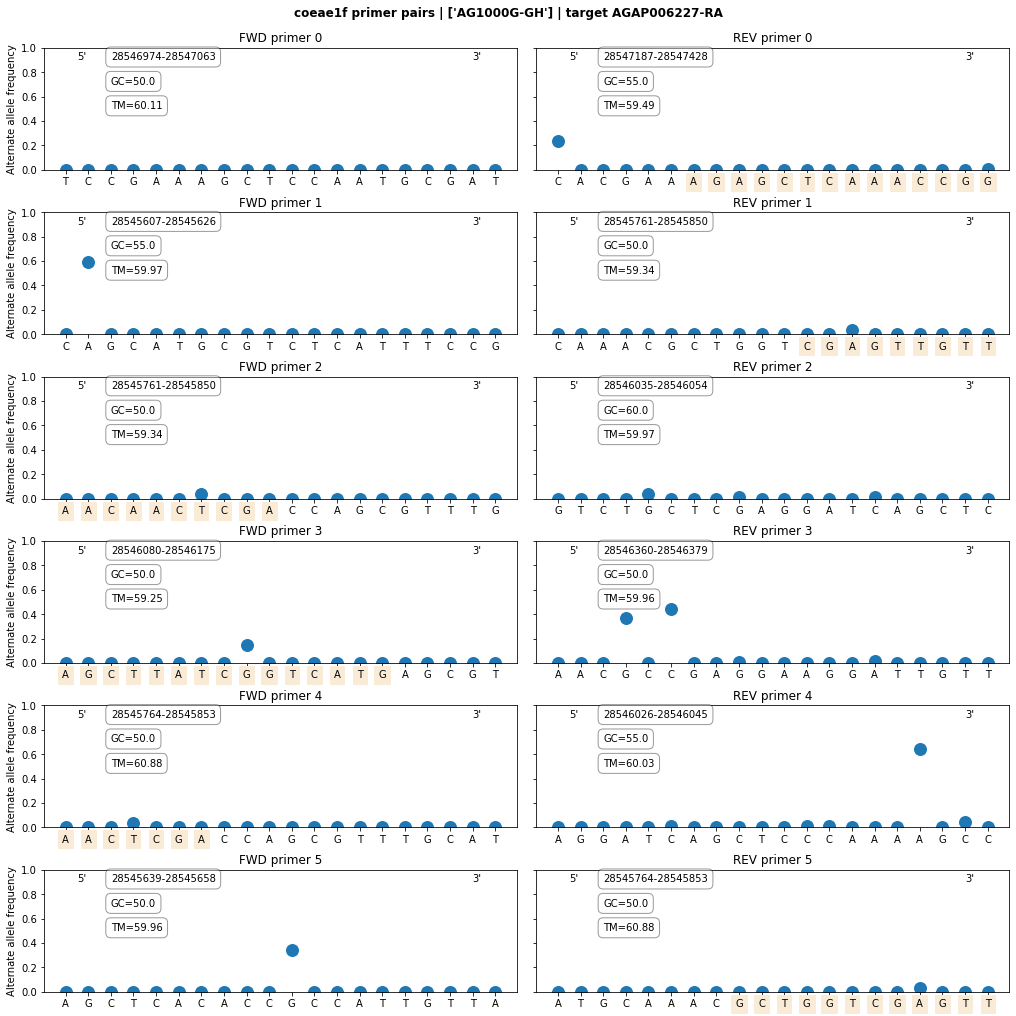

In [15]:
n_primer_pairs_to_plot = 6 # how many primer pairs to plot

if assay_type == 'gDNA':
  di_fwd, di_rev = agamPrimer.plot_primer_pairs(primer_df=primer_df, 
                                                gdna_pos=gdna_pos, 
                                                contig=contig,
                                                sample_set=sample_set, 
                                                n_primer_pairs=n_primer_pairs_to_plot , 
                                                assay=assay_type, 
                                                name=name,
                                                target=target_loc,
                                                save=True) 
elif assay_type == 'qPCR':
  di_fwd, di_rev = agamPrimer.plot_primer_pairs(primer_df=primer_df,
                                                gdna_pos=gdna_pos,
                                                contig=contig,
                                                sample_set=sample_set, 
                                                n_primer_pairs=n_primer_pairs_to_plot,
                                                assay=assay_type,
                                                name=name, 
                                                target=transcript,
                                                exon_junctions=exon_junctions,
                                                save=True)


In [16]:
primer_df

primer_pair,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
parameter,,,,,,,,,,,,,,,,,,,,
PRIMER_LEFT_SEQUENCE,TCCGAAAGCTCCAATGCGAT,CAGCATGCGTCTCATTTCCG,AACAACTCGACCAGCGTTTG,AGCTTATCGGTCATGAGCGT,AACTCGACCAGCGTTTGCAT,AGCTCACACCGCCATTGTTA,TTGCCGGTTTGAGCTCTTTC,AGTAAACAACTCGACCAGCGT,GGTATGCCAAGCTCCTTCGA,TGGCAGCTCCAGATCCTTAA,CCATTACCGGGCGCAATTTT,TCAAACCACCATTTCCGGGT,GCAGCTCCAGATCCTTAAAGC,ATTTTGCCGGTTTGAGCTCT,CGAATCGAGGGACAAAAATCCG,AACGAATCCCACAGCAGCAT,CACCGAACAGCGTCACATTG,GGGACAAAAATCCGAAAGCTCC,CCGGTTTGAGCTCTTTCGTG,CGCACGTTACGATCGCAAAA
PRIMER_RIGHT_SEQUENCE,CACGAAAGAGCTCAAACCGG,CAAACGCTGGTCGAGTTGTT,GTCTGCTCGAGGATCAGCTC,AACGCCGAGGAAGGATTGTT,AGGATCAGCTCCCAAAAGCC,ATGCAAACGCTGGTCGAGTT,ATCGGTGAGCGACGCTTTAA,GTCTACCGGTTTGCAGTGGA,GAAAGAGCTCAAACCGGCAA,AAAATGAGCCAGCCCGATCA,TTAAGGATCTGGAGCTGCCA,AGAGCTCAAACCGGCAAAAT,AAACGTGATCTGCTCCGGTT,GGTGAGCGACGCTTTAAGGA,ACAAGATCGTGGGCAGTGAG,AACGCTGGTCGAGTTGTTTAC,GGAGCTTTCGGATTTTTGTCCC,AAAATTGCGCCCGGTAATGG,ACGCTTTAAGGATCTGGAGCT,GGCTATTTAACGCTCATGACCG
PRIMER_LEFT_TM,60.107703,59.972806,59.344267,59.252745,60.884704,59.963836,59.048442,59.931873,59.821932,58.416444,59.825383,59.813614,59.053919,58.379178,59.969543,60.322816,60.110688,60.0947,59.487048,60.17927
PRIMER_RIGHT_TM,59.487048,59.344267,59.969362,59.963694,60.033699,60.884704,60.108992,59.965663,59.048442,60.034186,58.416444,58.379178,59.965104,60.389426,60.036952,59.137173,60.0947,59.825383,59.165737,59.778945
PRIMER_LEFT_GC_PERCENT,50.0,55.0,50.0,50.0,50.0,50.0,50.0,47.619048,55.0,50.0,50.0,50.0,52.380952,45.0,50.0,50.0,55.0,50.0,55.0,50.0
PRIMER_RIGHT_GC_PERCENT,55.0,50.0,60.0,50.0,55.0,50.0,50.0,55.0,50.0,50.0,50.0,45.0,50.0,55.0,55.0,47.619048,50.0,50.0,47.619048,50.0
PRIMER_LEFT,"(1366, 20)","(211, 20)","(365, 20)","(614, 20)","(368, 20)","(243, 20)","(1506, 20)","(361, 21)","(1331, 20)","(1642, 20)","(1488, 20)","(1314, 20)","(1644, 21)","(1503, 20)","(1348, 22)","(197, 20)","(1230, 20)","(1356, 22)","(1509, 20)","(476, 20)"
PRIMER_RIGHT,"(1528, 20)","(384, 20)","(588, 20)","(837, 20)","(579, 20)","(387, 20)","(1677, 20)","(546, 20)","(1525, 20)","(1803, 20)","(1661, 20)","(1522, 20)","(1842, 20)","(1674, 20)","(1571, 20)","(382, 21)","(1377, 22)","(1507, 20)","(1666, 21)","(642, 22)"
PRIMER_PAIR_PRODUCT_SIZE,163,174,224,224,212,145,172,186,195,162,174,209,199,172,224,186,148,152,158,167


**We may now have designed suitable primers. However, there are some further considerations...**


- Primers **must** be run in [**NCBI Blast**](https://blast.ncbi.nlm.nih.gov/Blast.cgi), to ensure specificity against the host organism, and specificity for the genomic location of interest. I would recommend both doing a general blast and also specifically against *An. gambiae* (TaxonID = 7165).

- If in multiplexed use with other primers or probes, primers must not interact with each other. This can be investigated using the IDT tool [oligoanalyzer](https://eu.idtdna.com/calc/analyzer).

- many more considerations.... (TODO)

.    
.     
.    
.    
.   
.   
.   
.   
.   
.   
.   
.    
.    
.    
.   
.    
.  
.   
. 


In [17]:
# #### code to plot genes and primer positions, not finished
# import matplotlib
# from matplotlib import patches

# def plot_genes_primers(contig, start, stop, n_primer_pairs, ax, di_fwd, di_rev):
#     # Load geneset (gff)
#     gff = ag3.geneset().query("start > @start & end < @stop")
#     genegff = gff.query("type == 'gene' & contig == @contig")
#     locgff = gff.query("type == 'exon' & contig == @contig")
#     min_= locgff.start.min()
#     max_ = locgff.end.max()
#     # configure axes
#     ax.set_xlim(min_, max_)
#     ax.set_ylim(-0.5, 2)
#     ax.axhline(0.5, color='k', linewidth=3)
#     #ax.set_yticks(ticks=[0.2,1.2], size=20)#labels=['- ', '+']
#     ax.tick_params(top=False,left=False,right=False,labelleft=True,labelbottom=True)
#     ax.tick_params(axis='x', which='major', labelsize=13)
#     ax.set_ylabel("Genes")
#     ax.set_xlabel(f"Chromosome {contig} position", fontdict={'fontsize':14})
#     # Add rectangles for exons one at a time 
#     for _, exon in locgff.iterrows():
#         start, end = exon[['start', 'end']]
#         strand = exon['strand']
#         if strand == '+':
#             rect = patches.Rectangle((start, 0.55), end-start, 0.3, linewidth=3,
#                                 edgecolor='none', facecolor="grey", alpha=0.9)
#         else:
#             rect = patches.Rectangle((start, 0.45), end-start, -0.3, linewidth=3,
#                                 edgecolor='none', facecolor="grey", alpha=0.9)
#         ax.add_patch(rect)

#     for _, gene in genegff.iterrows():
#         start, end = gene[['start', 'end']]
#         size = end-start
#         corr = size/4
#         strand = gene['strand']
#         if strand == '+':
#             rect = patches.Rectangle((start, 0.55), end-start, 0.3, linewidth=3,
#                                 edgecolor='black', facecolor="none")
#             ax.text(((start+end)/2)-corr, 0.95, s=gene['ID'], fontdict= {'fontsize':12})
#         else:
#             rect = patches.Rectangle((start, 0.45), end-start, -0.3, linewidth=3,
#                                 edgecolor='black', facecolor="none")
#            # ax.text(((start+end)/2)-corr,  -0.3, s=gene['ID'], fontdict= {'fontsize':12})
#         ax.add_patch(rect)

#         for pair in range(n_primer_pairs):
#           lower_fwd, upper_fwd = di_fwd[pair]['position'].min() , di_fwd[pair]['position'].max()
#           lower_rev, upper_rev = di_rev[pair]['position'].min() , di_rev[pair]['position'].max()
#           l = matplotlib.lines.Line2D([lower_fwd, upper_fwd], [-0.5 + (2.5/n_primer_pairs)*(pair+1), -0.5+(2.5/n_primer_pairs)*(pair+1)])
#           ax.add_line(l)
#           l = matplotlib.lines.Line2D([lower_rev, lower_rev], [-0.5 + (2.5/n_primer_pairs)*(pair+1), -0.5+(2.5/n_primer_pairs)*(pair+1)])
#           ax.add_line(l)

# fig, ax = plt.subplots(1,1, figsize=[12,8])
# plot_genes_primers(contig=contig, start=target_loc-200, stop=target_loc+200, n_primer_pairs=1, ax=ax, di_fwd=di_fwd, di_rev=di_rev)